###About Dataset

This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training and 25,000 for testing. So, predict the number of positive and negative reviews using either classification or deep learning algorithms.

* https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

* Source: Collected from the Internet Movie Database (IMDb).
* Structure: Contains movie reviews labeled as positive or negative.
* Size: Typically includes 50,000 reviews, balanced between the two sentiment categories.
* Use Case: Widely used for sentiment analysis and text classification tasks.
* Format: Available in formats like CSV or TSV for easy loading with pandas.
* Challenges: Includes nuances like sarcasm and varying expressions of sentiment.
* Applications: Useful for sentiment analysis in products, services, and movie recommendations.


In [103]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [87]:
df = pd.read_csv('/content/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [89]:
df.shape

(50000, 2)

In [90]:
df.isnull().sum()

,0
review,0
sentiment,0


In [91]:
# Dataset preprocessing
texts = df['review'].values
labels = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values

In [92]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

* TfidfVectorizer balances frequency with the uniqueness of the word across the dataset, making it better for capturing the relevance of words in context.

* CountVectorizer focuses purely on word frequency (counts), which can be helpful but may overemphasize commonly used words.


In [93]:
# Vectorization using TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

In [94]:
# Vectorize the text data using CountVectorizer
#vectorizer = CountVectorizer(max_features=10000, stop_words='english')
#X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
#X_test_tfidf = vectorizer.transform(X_test).toarray()

In [95]:
# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_tfidf, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_tfidf, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [96]:
# Define the feed-forward neural network model
class SentimentModel(nn.Module):
    def __init__(self, input_size):
        super(SentimentModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)  # Binary classification (positive or negative)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [97]:
# Initialize model, loss function, and optimizer
input_size = X_train_tfidf.shape[1]
model = SentimentModel(input_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/5, Loss: 0.3244743129968643
Epoch 2/5, Loss: 0.23966677974462508
Epoch 3/5, Loss: 0.21046488136053085
Epoch 4/5, Loss: 0.1503098551362753
Epoch 5/5, Loss: 0.0683410885721445


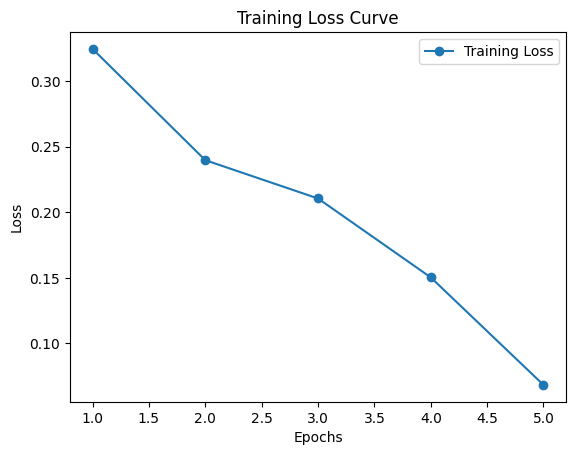

In [98]:
import matplotlib.pyplot as plt

# Training the model
epochs = 5
batch_size = 64

def train(model, X_train, y_train, criterion, optimizer, batch_size, epochs):
    model.train()
    train_losses = []  # List to store the loss for each epoch

    for epoch in range(epochs):
        permutation = torch.randperm(X_train.size()[0])
        epoch_loss = 0

        for i in range(0, X_train.size()[0], batch_size):
            indices = permutation[i:i+batch_size]
            batch_X, batch_y = X_train[indices], y_train[indices]

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / (len(X_train) / batch_size)
        train_losses.append(avg_loss)  # Store the average loss for this epoch
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss}")

    # Plot the loss curve
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o')
    plt.title('Training Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Call the train function
train(model, X_train_tensor, y_train_tensor, criterion, optimizer, batch_size, epochs)


In [99]:
# Evaluating the model
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)

    accuracy = accuracy_score(y_test_tensor, predicted)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test_tensor, predicted, average='binary')

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

Accuracy: 0.87
Precision: 0.86
Recall: 0.88
F1 Score: 0.87


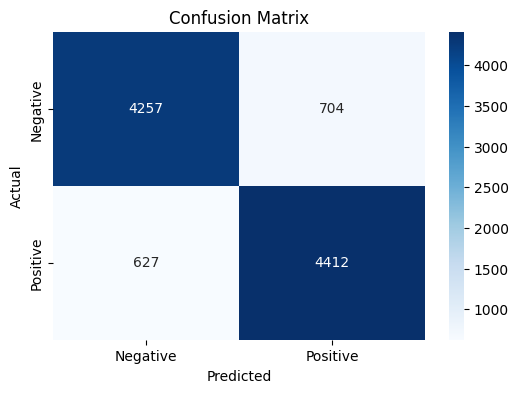

In [100]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test_tensor, predicted)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [101]:
# Prediction function
def predict(model, text):
    model.eval()
    vectorized_text = vectorizer.transform([text]).toarray()
    tensor_text = torch.tensor(vectorized_text, dtype=torch.float32)
    output = model(tensor_text)
    _, predicted = torch.max(output, 1)
    return 'positive' if predicted.item() == 1 else 'negative'

In [102]:
# Example prediction
sample_text = "The movie was absolutely amazing!"
predicted_label = predict(model, sample_text)
print(f"Predicted Sentiment: {predicted_label}")

Predicted Sentiment: positive


##Conclusion

The model demonstrated strong performance on the IMDb Movie Reviews dataset:

1. Using CountVectorizer0

* Loss: Decreased from 0.3211 to 0.0107 over five epochs, indicating effective learning.
* Accuracy: Achieved 88%, correctly classifying most reviews.
Precision: At 87%, it reliably identified positive predictions.
* Recall: With 89%, the model successfully captured most true positive reviews.
* F1 Score: At 0.88, it balanced precision and recall well.
* Prediction: Accurately classified the review "The movie was absolutely amazing!" as positive.


2.  Using TfidfVectorizer

* Loss: Decreased from 0.32447 to 0.06834 over five epochs, indicating effective learning.
* Accuracy: Achieved 87%, correctly classifying the majority of the reviews.
* Precision: At 86%, it reliably identified positive reviews.
* Recall: With 88%, the model successfully captured most true positive reviews.
* F1 Score: At 0.87, it showed a good balance between precision and recall.
* Prediction: Accurately classified the review "This movie was absolutely fantastic!" as positive.

